<a href="https://colab.research.google.com/github/K-kiran77/cataract-eye-disease-prediction/blob/main/Cataract_eye_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os
import shutil
import kagglehub

# Download to root (default behavior)
root_dataset_path = kagglehub.dataset_download('andrewmvd/ocular-disease-recognition-odir5k')

# Move to /content
content_dataset_path = '/content/dataset'
shutil.move(root_dataset_path, content_dataset_path)

print("Dataset moved to:", content_dataset_path)


100%|██████████| 1.62G/1.62G [01:14<00:00, 23.3MB/s]

Extracting files...


Dataset moved to: /content/dataset


In [ ]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array, ImageDataGenerator

from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Constants for data preparation

In [ ]:
## for VGG pre-trained model it only accepts a 224 x 224 image size
img_size = 224

## Import image description data

In [ ]:
# open xlsx file using the openpyxl engine

#df_data = pd.read_excel("../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx", engine = 'openpyxl')
#df_data.head()

# open csv file (note - target and filename only references one single eye)

df_data = pd.read_csv("/content/dataset/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


### Ocular disease map

* Normal (N),
* Diabetes (D),
* Glaucoma (G),
* Cataract (C),
* Age related Macular Degeneration (A),
* Hypertension (H),
* Pathological Myopia (M),
* Other diseases/abnormalities (O)

### Exploratory data analysis

One big issue with this data set is that it has images for BOTH left and right eyes in separate files, which totally makes sense since as humans we have two eyes.  However, in the numeric encoded diagnosis (the columns labeled C, D, G...) it doesn't specify the left or right eye, the logic is that if there was any eye with an issue, then a 'true' '1' would result.  '1' doesn't tell us if this was a left or right eye, and in some queries this doesn't matter, but when we pull our image files, this becomes and issue.

We really need to go by the data from the keyword diagnosis, if there is a

Let's take a look at the keywords of images that have a cataract diagnosis

In [ ]:
df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


It seems safe to say that if either eye has a cataract, then it is properly labeled in the keywords column of that eye with the word "cataract".  At this point, it's safe to go ahead and ignore the encoded columns since they simply don't provide accurate mapping to our left/right eye requirements when we process the left/right images.

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

### Find the number of positive "1" results in the dataset.  

We will look at the columns (this is the axis=0 flag) and count all the '1' in it.

In [ ]:
df_data[df_data == 1].sum(axis=0)

,0
ID,2.0
Patient Age,28.0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,2101.0
D,2123.0
G,397.0


## Problems with the encoded categories

We found that relying on the encoded diagnosis categories "N	D	G	C	A	H	M	O" could be problematic in the sense that some of the values were positive for both normal and disease eyes, but didn't specify which eye. The problem with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information.  If we use the categories exclusively, we run into the problem later on where pulling specific eye orientation data is impossible as it is lost in the encoded categories.  

Therefore we will exclude those categories for this notebook although they could certainly be used for other investigations.

In [ ]:
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


## Set up file paths



In [ ]:
img_dir = "/content/dataset/preprocessed_images"

## Select only Cataract related data

Since we can't rely on the encoded categories, we will search for terms in the keywords columns for each eye.

In [ ]:
# Left diagnosis with 'cataract' keyword

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [ ]:
## let's place the left cataract data into its own dataframe and print the number of rows

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [ ]:
# Right diagnosis with 'cataract' keyword

df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [ ]:
## let's place the right cataract data into its own dataframe and print the number of rows

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


## Combine cataract filename data

To view, parse and run loops on images it is much more convenient to have all the cataract images in one dataframe as a single column.  We will append only the image filenames into a new dataframe.

In [ ]:
df_cat_filenames = pd.concat([df_left_cat['Left-Fundus'], df_rt_cat['Right-Fundus']], ignore_index=True)
df_cat_filenames.head()



,0
0,0_left.jpg
1,103_left.jpg
2,119_left.jpg
3,254_left.jpg
4,294_left.jpg


We can see that the left images were first and then let's check to make sure the tail end of the dataframe has the right eye images.

In [ ]:
df_cat_filenames.tail()

,0
567,2243_right.jpg
568,2246_right.jpg
569,2247_right.jpg
570,2248_right.jpg
571,2282_right.jpg


Let's find out how many rows of cataract images we're working with


In [ ]:
len(df_cat_filenames)

572

## View example images

Now we have a dataframe of images, let's take a look at a few.  Note that when the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red).  Let's select a random image from our dataframe.

(512, 512, 3)
2120_right.jpg


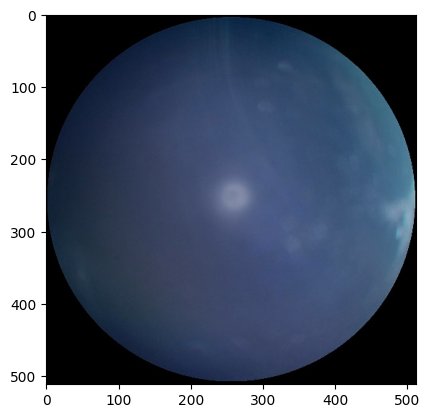

In [ ]:
img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

## Create grid of example images

From our cataract set of image file paths, let's create a comparitive grid to see what cataracts actually looks like.  We'll convert them to a more realistic RGB pallete as well.

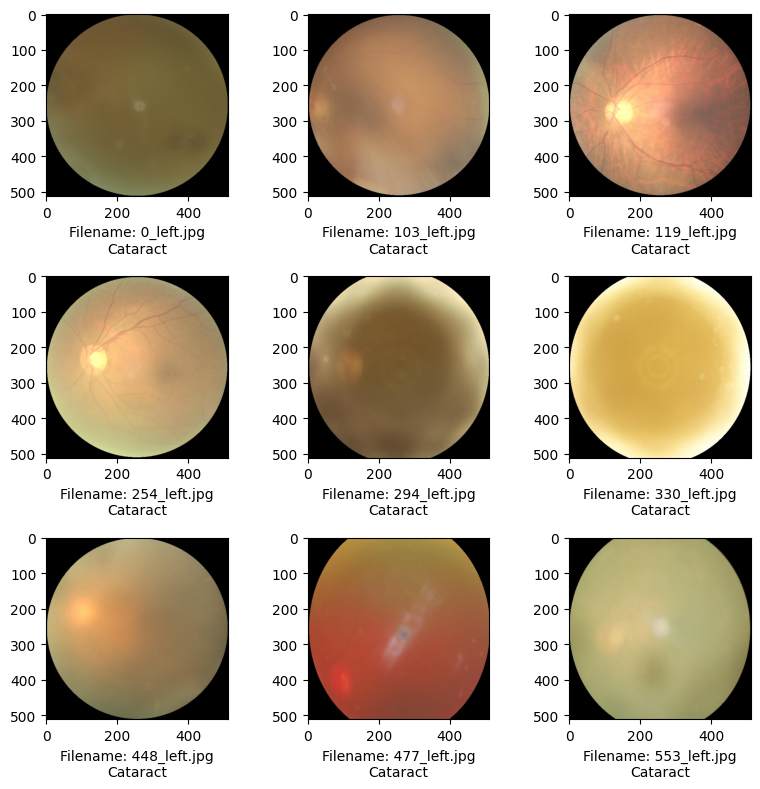

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout()

## Gather the normal images
We now need to gather a set of normal images.  First let's see how many normal images there are available to us - we did this earlier but let's take a look again.  Remember, we're working with two eyes and we noticed that some of the encoded columns don't have data for both eyes, so the whole story is not truly told.  We need to look at the labeling in the keywords as that seems to be the source of truth when considering both eyes.

In [ ]:
df_data[df_data == 1].sum(axis=0)

,0
ID,2.0
Patient Age,28.0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,2101.0
D,2123.0
G,397.0


We see 2101 "normal" encoded results, but we can't really trust this since this may not take into account both eyes.  Let's check out the keyword results that contain "normal", separately for both eyes:

In [ ]:
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


So if we add these up we have over 5000 images to choose from (comprised of both left and right side eye images) that are considered "normal".  This is far more than we have for our 'cataract' data that had only 572 images.  So, in that case let's pull an equal amount of randomly selected "normal" images.

## Combine normal filename data

In [ ]:
df_norm_filenames = pd.concat([df_left_norm['Left-Fundus'], df_rt_norm['Right-Fundus']], ignore_index=True)
df_norm_filenames

,0
0,1_left.jpg
1,8_left.jpg
2,9_left.jpg
3,14_left.jpg
4,15_left.jpg
...,...
5585,4642_right.jpg
5586,4644_right.jpg
5587,4660_right.jpg
5588,4671_right.jpg


## Select and create a random set

In [ ]:
## remember we're choosing 572 to equal the number of cataract images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

,0
2167,2834_left.jpg
4076,3345_right.jpg
3394,2603_right.jpg
4748,2602_right.jpg
676,2797_left.jpg


In [ ]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

,0
0,2834_left.jpg
1,3345_right.jpg
2,2603_right.jpg
3,2602_right.jpg
4,2797_left.jpg
...,...
567,2791_left.jpg
568,903_left.jpg
569,3444_right.jpg
570,737_left.jpg


Looks like the random sampling

## Create a grid of "normal" images

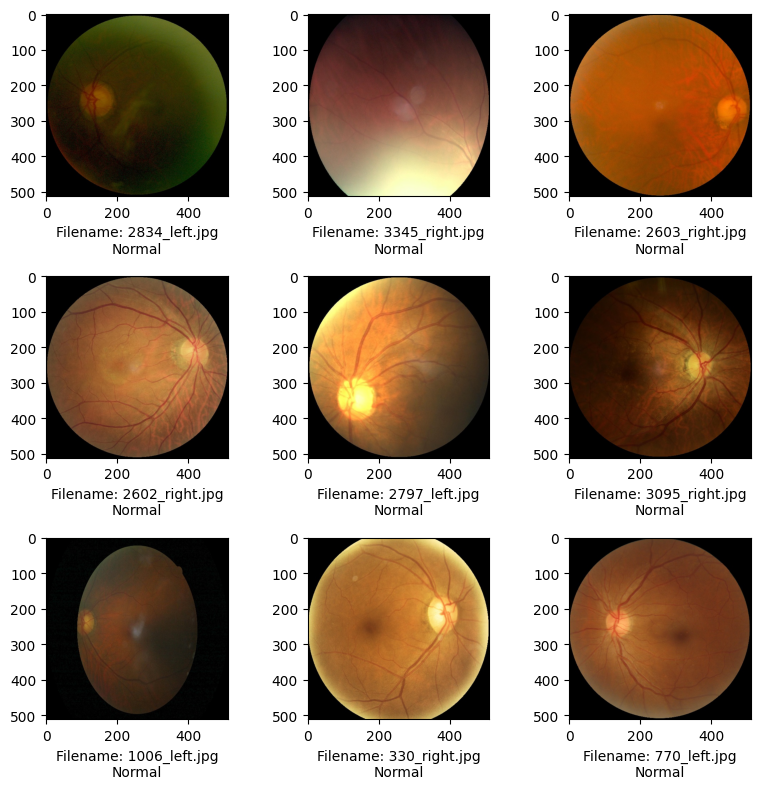

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout()

## Add category label to list

Previously we created these two objects that weren't true dataframes, they became lists after we did an append of columns.  For convenience, we need to turn them back into dataframes:

- df_norm_filenames_random
- df_cat_filenames

Images will be labeled normal or cataract, in this case we will be using an image data generator that will do the one-hot-encoding for us, so we can preserve the actual "word" string labels.

In [ ]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [ ]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2834_left.jpg,normal
1,3345_right.jpg,normal
2,2603_right.jpg,normal
3,2602_right.jpg,normal
4,2797_left.jpg,normal


## Append dataframes into a single dataset

We have both cataract and normal dataframes with labels, we need to combine them to form a single dataframe to feed into our image generator.


In [ ]:
df_combined = pd.concat([df_cat_filenames, df_norm_filenames_random], ignore_index=True)
df_combined

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1139,2791_left.jpg,normal
1140,903_left.jpg,normal
1141,3444_right.jpg,normal
1142,737_left.jpg,normal


## Randomize our final combined dataset

Prior to feeding this organized set of cataract and normal images we need to randomize the rows within so that when we train we will train from a random pool of samples.

If we append, we end up adding a column for the old index values, which we don't want any new columns, so we'll drop the old index and allow the new dataframe to have a new one.

In [ ]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2128_left.jpg,cataract
1,2384_right.jpg,normal
2,2097_right.jpg,cataract
3,789_left.jpg,normal
4,2181_left.jpg,cataract
...,...,...
1139,3230_right.jpg,normal
1140,2787_right.jpg,normal
1141,2116_right.jpg,cataract
1142,218_right.jpg,cataract


## Split our dataframe into test, train, validation dataframes

Since we're going to continue to use a dataframe with a labels column, we can't use the common sklearn test-train-split function.  we will instead simplify things and create three data frames by pulling random samples out and then excluding those samples from another set by using the drop method.

In [ ]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1144
915
229


## Image Generator flow from Dataframe

This was developed by:  https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

We have a nice dataframe that we have created and Keras combined with this handy function will allow us to generate augmented and scaled images with minimal effort.  

Here we will add some parameters that will perform some adjustment to the images.

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

## Convert row objects to string type

Although flow from dataframe will work with other datatypes, I kept getting errors that were requesting to convert the dataframe rows into string type.

In [ ]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

## Create test, train and validation image data generators

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set,
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


## Image generator results

Let's look at the actual data that gets created from the image generator.  The "next" command splits the generator data into two numpy arrays - one with image data and one with label data.

In [ ]:
train_image_data, train_labels = next(train_generator)
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

Let's look at the label format

In [ ]:
train_labels[0]

array([1., 0.], dtype=float32)

Let's grab a single augmented image

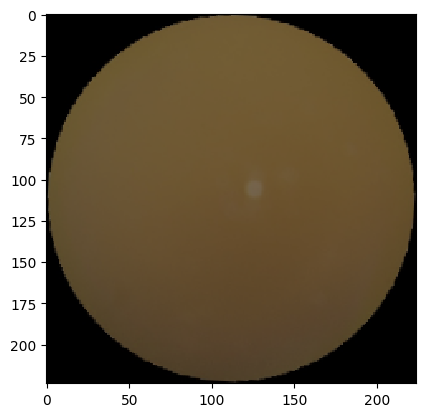

In [ ]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()
#images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

## Augmented image examples

Let's make a grid of data augmented images

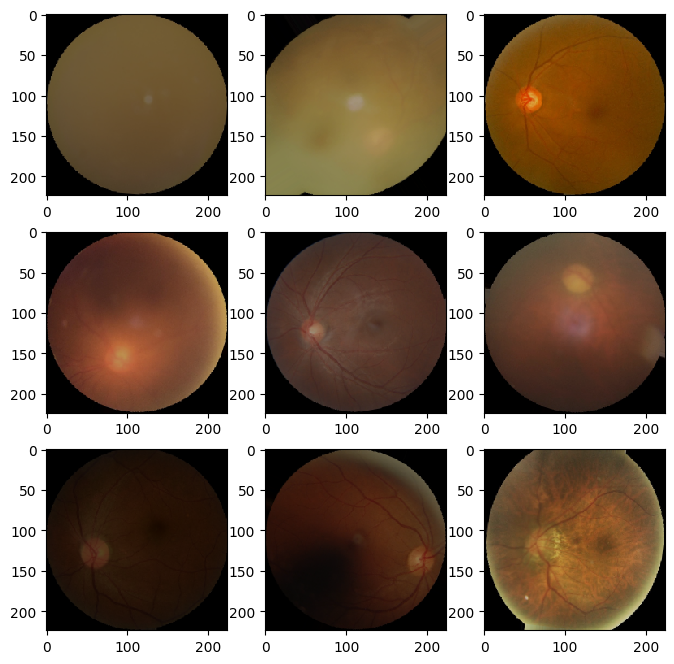

In [ ]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_image_data[i], interpolation='nearest')

plt.show()

## The VGG16 model diagram

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

https://neurohive.io/en/popular-networks/vgg16/

## Build our transfer learning model

Here we load the vgg16 model, but since we are doing transfer learning, we don't want the fully connected portion, so we will rip it off with the include_top FALSE option.  We don't want this because we have a custom dataset that has a custom number of outputs, 2 in this case.

We will use the 'imagenet' weights since those filters / weights / kernels will help us find edges, corners, rounded areas of our images.  Those are already baked in and we can speed this process up by using some that are proven to be effective for thousands of images.

We will drop 50% of the perceptrons during the final layer to avoid overfitting.

We will use the ADAM gradient descent optimizer as well.

In [ ]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,537,282 (154.64 MB)

 Trainable params: 25,822,594 (98.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Create check point and early stop

A check point allows us to monitor the acuraccy and perform some task, in this case we will save the model as a file.

The early stop will monitor accuracy for a 'patience' parameter and if there is no improvement it will stop.

In [ ]:
checkpoint = ModelCheckpoint("trained.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=3,
                      verbose=1,
                      mode='auto')


From:  https://stackoverflow.com/questions/46820609/how-the-keras-steps-per-epoch-in-fit-generator-works

The steps_per_epoch parameter is the number of batches of samples it will take to complete one full epoch. This is dependent on your batch size. The batch size is set where you initialize your training data. For example, if you're doing this with ImageDataGenerator.flow() or ImageDataGenerator.flow_from_directory(), the batch size is specified with the batch_size parameter in each of these.

With 3000 samples for example:

```
If your batch size was 100, then steps_per_epoch would be 30.
If your batch size was 10, then steps_per_epoch would be 300.
If your batch size was 1, then steps_per_epoch would be 3000.
```

This is because steps_per_epoch should be equivalent to the total number of samples divided by the batch size. The process of implementing this in Keras is available in the two videos below.

## Constants for our training run

SPE is 'steps per epoch'

n_val_steps is 'number of validation steps'

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

22 5


In [ ]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        #workers=5,
                        #use_multiprocessing=True,
                        callbacks=[checkpoint,early])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5901 - loss: 1.5218
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to trained.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5920 - loss: 1.5054 - val_accuracy: 0.8062 - val_loss: 0.4595
Epoch 2/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.5312 - loss: 0.8543

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.80625 to 0.84375, saving model to trained.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.5312 - loss: 0.8543 - val_accuracy: 0.8438 - val_loss: 0.3871
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6877 - loss: 0.6522
Epoch 3: val_accuracy did not improve from 0.84375
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 619ms/step - accuracy: 0.6888 - loss: 0.6505 - val_accuracy: 0.7563 - val_loss: 0.4604
Epoch 4/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7812 - loss: 0.4684
Epoch 4: val_accuracy did not improve from 0.84375
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.7812 - loss: 0.4684 - val_accuracy: 0.6812 - val_loss: 0.5779
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.7091 - loss: 0.6369
Epoch 5: val_accuracy did not improve from 0.84375
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 750ms/step - accuracy: 0.7108 - loss: 0.6335 - val_accuracy: 0.8375 - val_loss: 0.3679
Epoch 5: early stopping


## Load our saved model

In [ ]:
from keras.models import load_model
model = load_model('./trained.h5')


## Plot accuracy versus loss

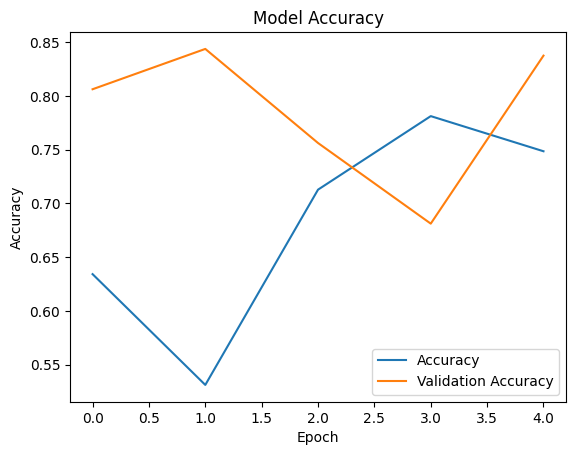

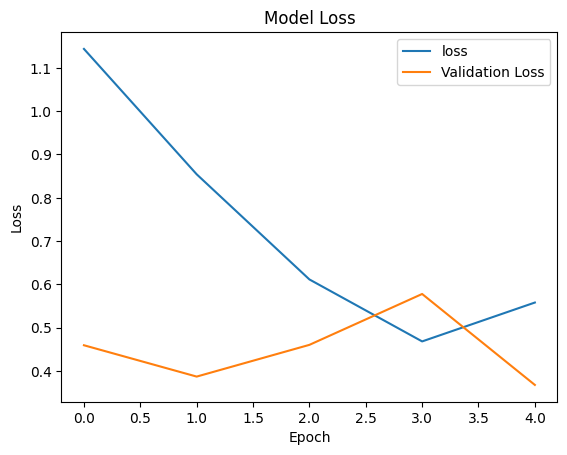

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

## Make our predictions with predict.generator

We have several generators that feed a set batch size of image data into whatever we want, whenever we call the generator iterator.  We need to reset the test generator so that we aren't feeding any old image data further down the line.

The prediction output is only a set of categorical labels of 0 and 1 - in this case Cataract is 0 and normal is 1.  The prediction output is NOT image data.

In [ ]:
test_generator.reset()

In [ ]:
pred = model.predict(test_generator,verbose=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step


## Prediction raw data

Let's look at what the predict generator outputs to get some better insight into what the mechanics of the model output really are!

In [ ]:
## let's get the first 10 rows
print(pred[0:10])

[[9.6497816e-01 3.5021894e-02]
 [3.6142766e-03 9.9638569e-01]
 [9.0677881e-05 9.9990928e-01]
 [9.6178788e-01 3.8212117e-02]
 [2.7636132e-05 9.9997234e-01]
 [3.2539465e-03 9.9674606e-01]
 [9.5654327e-01 4.3456707e-02]
 [9.7157007e-01 2.8429907e-02]
 [1.1796272e-01 8.8203722e-01]
 [6.2062325e-05 9.9993789e-01]]


In [ ]:
pred

array([[9.64978158e-01, 3.50218937e-02],
       [3.61427665e-03, 9.96385694e-01],
       [9.06778805e-05, 9.99909282e-01],
       [9.61787879e-01, 3.82121168e-02],
       [2.76361316e-05, 9.99972343e-01],
       [3.25394655e-03, 9.96746063e-01],
       [9.56543267e-01, 4.34567071e-02],
       [9.71570075e-01, 2.84299068e-02],
       [1.17962718e-01, 8.82037222e-01],
       [6.20623250e-05, 9.99937892e-01],
       [7.46509433e-01, 2.53490567e-01],
       [6.11967504e-01, 3.88032466e-01],
       [3.08252813e-04, 9.99691725e-01],
       [4.78426833e-03, 9.95215774e-01],
       [3.46749694e-05, 9.99965310e-01],
       [8.75473022e-01, 1.24527030e-01],
       [5.10306098e-04, 9.99489665e-01],
       [1.30219191e-01, 8.69780838e-01],
       [9.53674614e-01, 4.63253334e-02],
       [9.73085940e-01, 2.69140638e-02],
       [9.73112822e-01, 2.68872287e-02],
       [8.53479445e-01, 1.46520540e-01],
       [9.66161907e-01, 3.38381045e-02],
       [8.17485511e-01, 1.82514518e-01],
       [8.323702

## Convert raw prediction data

Let's convert the raw data into something more friendly, 1's and 0's.  Argmax will do this for us!

In [ ]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[0 1 1 0 1 1 0 0 1 1]


we're still working with the full set of labels from our generator

In [ ]:
print(len(predicted_class_idx))

229


## Evaluate our model's accuracy

In [ ]:
model.save('t.h5')

In [ ]:
model.evaluate(test_generator)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9084 - loss: 0.2968


[0.2931108772754669, 0.9082969427108765]

## Convert one-hot category labels to text labels

1's and 0's are great, but we are going to eventually need the actual text names.

The generators have lots and lots of parameters for you to use.

In [ ]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

Use the training label string name keys (cataract and normal) and convert the one-hot encoded predicted class labels into string names.  What these lines do is grab the name of the category (the value) and place it into the predicted labels variable where it meets the criteria of the value.

In [ ]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [ ]:
pred_labels[1:10]

['normal',
 'normal',
 'cataract',
 'normal',
 'normal',
 'cataract',
 'cataract',
 'normal',
 'normal']

## Build a new dataframe

We don't actually need to do this, but, building a new dataframe can be beneficial if you need to do any prediction lookups that require a dataframe, or you could export this out into a CSV.  Pretty handy to have around.

In [ ]:
num_predictions = pred.shape[0]

# Trim the filenames list to match the number of predictions
filenames = test_generator.filenames[:num_predictions]

# Now create the DataFrame
prediction_df = pd.DataFrame({'Filename': filenames, 'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,2384_right.jpg,cataract
1,2776_right.jpg,normal
2,4197_left.jpg,normal
3,2203_left.jpg,cataract
4,2965_left.jpg,normal


## Verify prediction dataframe results

Since we want to prove that our test data is indeed being tested, let's verify that our prediction data is indeed aligned with the test filename, row and diagnosis.

In [ ]:
prediction_df.iloc[35]

,35
Filename,2932_right.jpg
Prediction,normal


Compare that same row to our test generator data

In [ ]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2932_right.jpg
1


## Correct vs. Incorrect list

Now that we have lightly verified our test and prediction data is aligned, we can list all of our predictions and compare them to our test data.  This is only an example using a small test dataset (under 1000).  I can't possibly recommend this for a large dataset.

In [ ]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={}

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]

    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "


    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Wrong     cataract    normal      2384_right.jpg
 Correct   normal    normal      2776_right.jpg
 Correct   normal    normal      4197_left.jpg
 Correct   cataract    cataract      2203_left.jpg
 Correct   normal    normal      2965_left.jpg
 Correct   normal    normal      467_left.jpg
 Correct   cataract    cataract      2182_right.jpg
 Correct   cataract    cataract      2262_left.jpg
 Correct   normal    normal      2558_left.jpg
 Correct   normal    normal      4590_right.jpg
 Correct   cataract    cataract      2126_left.jpg
 Wrong     cataract    normal      2977_right.jpg
 Correct   normal    normal      3142_left.jpg
 Correct   normal    normal      3418_right.jpg
 Correct   normal    normal      2564_right.jpg
 Correct   cataract    cataract      1435_left.jpg
 Correct   normal    normal      2666_right.jpg
 Wrong     normal    cataract      1415_left.jpg
 Correct   cataract    cataract      2218_

flow() returns an iterator yielding tuples of (x, y), you can access elements using test_iterator.next().

## Another approach to generator data

You can split your test generator data another way by using 'next'.  This will trigger the generator to only give you the amount of data in your batch size variable, so don't expect this is exactly like the previous method.  Each time you trigger the test generator, or any generator, you are only going to get a limited amount.

Here we are splitting the test generator object data into two numpy arrays, one with actual image data and one with label data.

In [ ]:
x_test, y_test = next(test_generator)

In [ ]:
x_test.shape

(32, 224, 224, 3)

In [ ]:
print(len(x_test))
print(len(y_test))


## compare this length to our prediction data and notice the difference.

print(len(pred))

32
32
229


We can use this also as a gauge for evaluating our model's accuracy, this of course should be relatively close to our accuracy from the previous model predict function.

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8750 - loss: 0.3850
loss: 0.38496366143226624
Accuracy: 0.875


## Prediction vs Test image grid

We're working with images, so let's actually look at the results of our prediction vs test images.

Let's grab our test data items, the image array and the encoded image category.  Let's start by renaming them to something more friendly.

In [ ]:
test_image_data, test_labels = next(test_generator)

Take a look at the shape difference in these arrays.  The shapes should clue you in and make sense about the data within them.  

The shape of the image data structured like this:

( NUMBER OF ROWS, DIMENSION, DIMENSION, DEPTH)

Let's unpack the shape:

- For images this is pretty clear, we have 32 samples gathered by our test generator
- 224 in the horizontal dimensions of the image
- 224 in the vertical dimension of the image
- 3 depth since this is a color image

While the label data is structured like this:

- 32 samples
- 2 depth since we have 2 outputs, the numerical probablity of each of our categories

In [ ]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In our grid we'd like to see a few parameters such as filename, label and categorical value (1, 0).

Let's test the output of those parameters from the generators

In [ ]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

2384_right.jpg
1


'cataract'

In [ ]:
### keep
### show all test labels
#test_generator.labels

## Convert test labels

Let's look at a single example of our test label data

In [ ]:
test_labels[5]

array([1., 0.], dtype=float32)

Convert our test label tuples into a single one dimensional array with argmax.

It's clear to see the entire test labels array is only 32 elements since this is the batch size limit that was set in the generator parameters.

In [ ]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

## Plot our comparison grid

The data generator encoded our categories for us, whereby cataract = 0 and normal = 1.  Since we are using image generators we will only be able to gather 32 images at a time since this is the batch size we set.  If we increase our batch size, the generator will gather more images and send them through the fit function during training

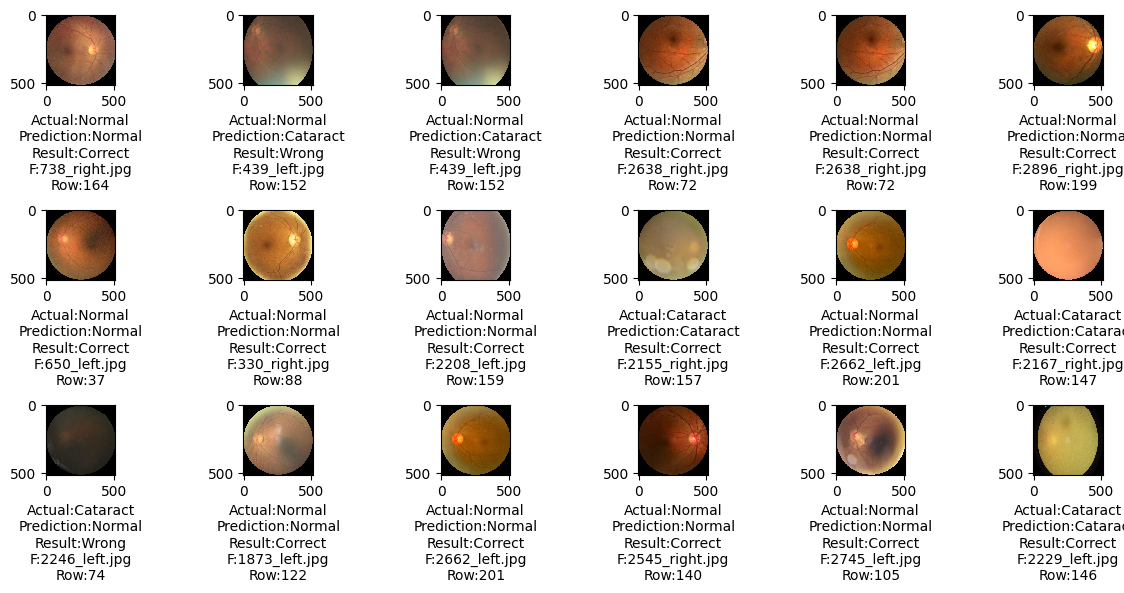

In [ ]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]


    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"


    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout()

## Classification report

In [ ]:
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Cataract       0.93      0.89      0.91       119
      Normal       0.89      0.93      0.91       110

    accuracy                           0.91       229
   macro avg       0.91      0.91      0.91       229
weighted avg       0.91      0.91      0.91       229



## Confusion matrix

Code from:  https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

A confusion matrix is an EXTREMELY HANDY WAY of displaying the amount of correct vs. incorrect predictions.  But the raw confusion matrix output is a pretty basic array.  This can be plotted to be much more friendly to read.

In [ ]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[106,  13],
       [  8, 102]])

## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['cataract','normal']

We can see that the y-axis is the true (test) labels and the x-axis is the predicted output.  

Correct items are where both the true and predicted cells meet - the categories are similar, in this case, a darker color.

Incorrect items are lighter in color and are where the true and predicted cells have disimilar categories.

Confusion matrix, without normalization
[[106  13]
 [  8 102]]


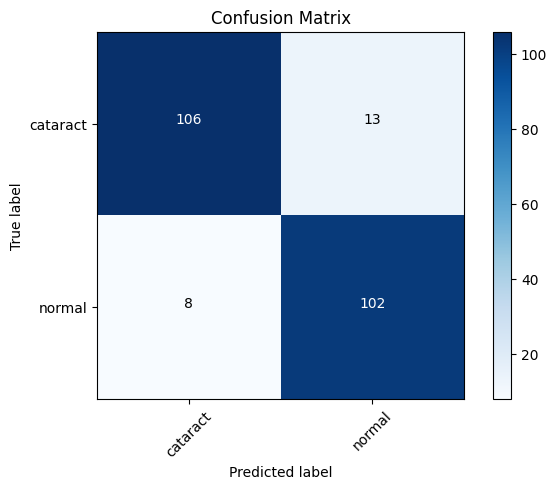

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,537,284 (154.64 MB)

 Trainable params: 25,822,594 (98.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)